[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/tutorial-simple-sampler.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax
from jax import vmap
import matplotlib.pyplot as plt
from getdist import MCSamples, plots

import sys
import os
sys.path.append("../")
from pldflow import plflow
from pldflow import sampler

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: Point lens

In [4]:
class PointLens(plflow.PicardLefschetzModelBaseClass):
    # Here the ndim is the dimension of x. 
    ndim = 2
    def action_s(self, z, y, w=1):
        geo = 0.5*jnp.dot(z-y,z-y)
        pot = jnp.log(jnp.dot(z,z)**0.5)
        return -1j * w * (geo - pot)

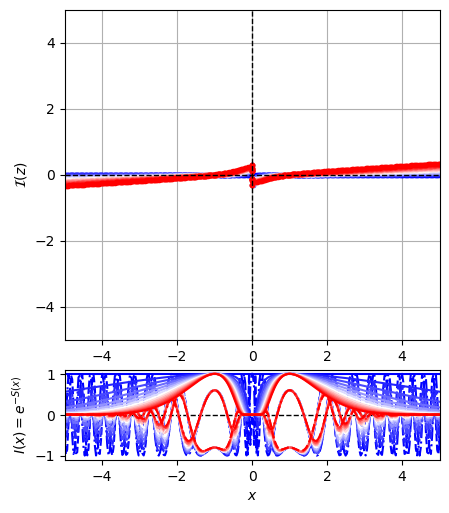

In [23]:
w = 5.0
tmax = 0.07
ntbin= 15

# instantiate the model
pl = PointLens(ndim=1)

t = jnp.linspace(0, tmax/w, ntbin)
x = jnp.linspace(-5,5,300).reshape(-1,1)
y = jnp.array([0.0])

fig, axes = pl.plot1d(x,t=t,y=y, w=w)
# Okay from this plot, we see that tmax=0.2 is large enough 
# to make the integrand less oscilating.
# And using larger tmax makes the peak width too small 
# making it difficult to sample efficint.

In [24]:
pl = PointLens(ndim=2)

## Conditional Sampler

In [25]:
# we define the log likelihood to be sampled

# PL flow time
t = jnp.linspace(0, tmax/w, ntbin)

def like(x, y):
    z = pl.flow(x=x, t=t, y=y, w=w)
    j = pl.flow_jacobian(x=x, t=t, y=y, w=w)
    return -pl.action_s(z, y).real + jnp.log(jnp.abs(j))

In [26]:
# Define the range of variable to sample
# The format is 
# {'x':(min, max, ndim)}
xranges = {'x':(-7,7,pl.ndim), 'y':(-5, 5, pl.ndim)}
# Instantiate the sampler
csampler = sampler.ConditionallikelihoodSampler(like, xranges)

In [27]:
# turn off
import warnings
warnings.filterwarnings("ignore", message="There are not enough devices to run parallel chains")

# Now sample using Hamiltonian Monte Carlo
# Inputs are (num_warmup, num_xsamples, num_chains)
# - num_warmup: number of warmup samples (i.e. burnin)
# - num_xsamples: number of samples to draw per chain
# - num_chains: number of chains (this shoulbe large especially when multimodal, to avoid local minima)
%time csampler.sample_xsamples(100, 100, 100, progress_bar=True)

# this will give you 70*70=4900 samples

sample: 100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 172.57it/s, 7 steps of size 1.70e-01. acc. prob=0.94]


CPU times: user 2min 19s, sys: 15.5 s, total: 2min 35s
Wall time: 1min 56s


Removed no burn in


<Figure size 600x600 with 0 Axes>

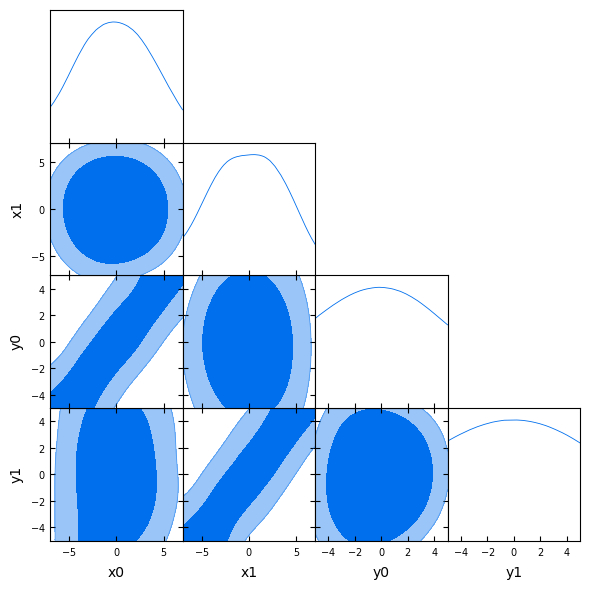

In [28]:
# Show the distribution
mcs = MCSamples(samples=csampler.xsamples, names=csampler.xnames, ranges=csampler.xranges)

g = plots.get_single_plotter(ratio=1)
g.triangle_plot([mcs], filled=True)
plt.show()

## A Simple Proposal distribution (the main idea of this notebook)
In this notebook, we use a very simple sampler as a proposal distribution which is constructed based on the above samples.

This is based on the fact that the dependence of the distribution of samples on the primary model parameter in the lensing problem, the impact parameter $y$, can be approximated by a very simple way, $x\propto y$ as can be seen in the above plot.

We first introduce the shift $(x,y)\rightarrow (x-y, y)$, and then construct the proposal distribution by the inverse function method for each dimension of the integral variable $x$.

In [47]:
xsamples = csampler.xsamples[:, :pl.ndim]
ysamples = csampler.xsamples[:, pl.ndim:]

In [48]:
xysamples = xsamples - ysamples
# xysamples = jnp.vstack([xysamples, -xysamples])

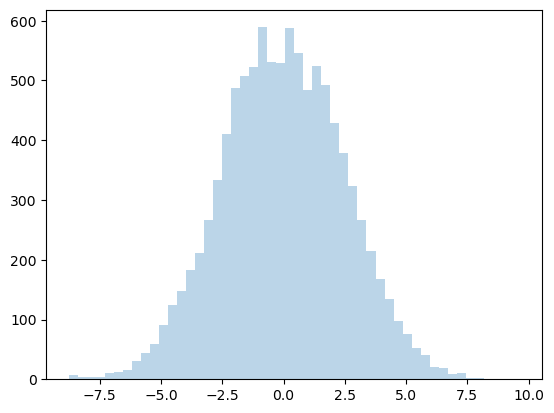

In [49]:
plt.hist(xysamples[:,0], bins=50, color='C0', alpha=0.3)
plt.show()

In [50]:
%time isampler = sampler.InverseFunctionaSampler(xysamples, thin=20)

CPU times: user 19.5 ms, sys: 12.4 ms, total: 32 ms
Wall time: 50.9 ms


In [33]:
# %time z = isampler.sample_z(1000)
%time z, lnp = isampler.sample_u_and_lnp(1000)
# %time xy = isampler.sample_x(1000)
%time xy, lnp = isampler.sample_x_and_lnp(10000)

CPU times: user 977 µs, sys: 599 µs, total: 1.58 ms
Wall time: 911 µs
CPU times: user 21.2 ms, sys: 3.73 ms, total: 25 ms
Wall time: 18.2 ms


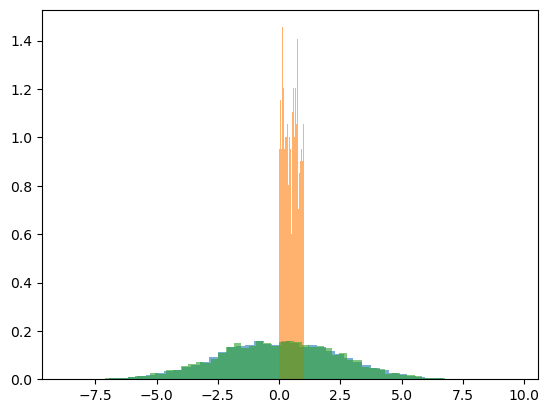

In [51]:
plt.hist(xysamples[:,0], bins=50, alpha=0.6, density=True)
plt.hist(z[:,0], bins=50, alpha=0.6, density=True)
plt.hist(xy[:,0], bins=50, alpha=0.6, density=True)
plt.show()

Okay, now let's perform the integral based on the importance sampling with the proposal distribution.

In [52]:
def perform(y, size=10_000):
    xy, lnp = isampler.sample_x_and_lnp(size)
    Z, dZ  = pl.integrate(xy+y, lnp, t, y=y, w=w, error=True, min_lnp=-6)
    return Z, dZ
vperform = jax.vmap(perform, in_axes=0, out_axes=0)

In [53]:
y1 = jnp.linspace(0.0, 10.0, 300)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2], axis=1)
%time Z, dZ = vperform(y)

CPU times: user 64 ms, sys: 38.6 ms, total: 103 ms
Wall time: 42 ms


In [54]:
def get_analytic(y1, w):
    fname = '../data/Fpl_w{:.1f}.dat'.format(w)
    assert os.path.exists(fname), 'Analytic solution not found'
    import numpy
    y, fpl_r, fpl_i = numpy.loadtxt(fname, unpack=True)
    fpl = fpl_r + 1j*fpl_i
    return jnp.interp(y1, y, fpl)
Za = get_analytic(y1, w) 

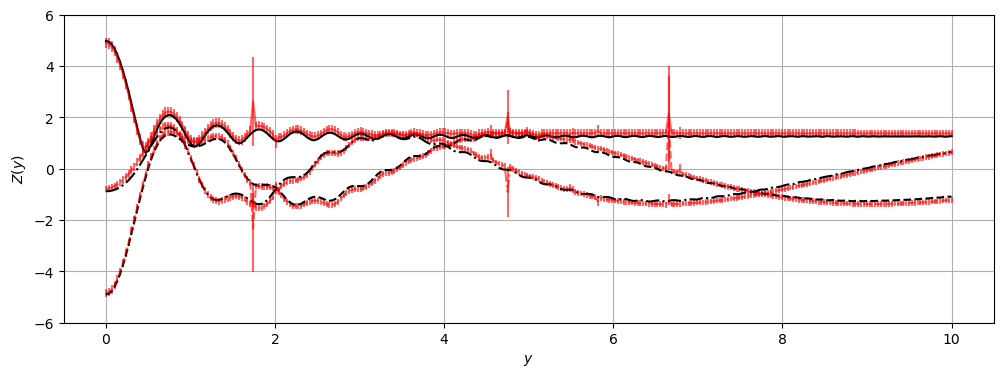

In [55]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.errorbar(y1, jnp.real(Z), jnp.real(dZ), color='r', ls='--', alpha=0.6)
plt.errorbar(y1, jnp.imag(Z), jnp.imag(dZ), color='r', ls='-.', alpha=0.6)
plt.errorbar(y1, jnp.abs(Z) , jnp.abs(dZ) , color='r', ls='-' , alpha=0.6)
# exact
plt.plot(y1, jnp.real(Za), color='k', ls='--')
plt.plot(y1, jnp.imag(Za), color='k', ls='-.')
plt.plot(y1, jnp.abs(Za) , color='k', ls='-')

plt.ylim(-6,6)
plt.grid()
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.show()